# **Libraries**

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import time
import pickle
import random
import json 

from PIL import Image
from PIL import ImageDraw

import os
# import multiprocessing
from tqdm import tqdm
from tqdm.keras import TqdmCallback
train_on_gpu = True

from collections import Counter

from IPython.display import FileLink

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

2024-10-21 14:30:21.918781: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 14:30:21.918905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 14:30:22.056204: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print(tf.__version__)

2.15.0


In [3]:
# Supress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# **Directories**

In [25]:
# Directory names
main_dir = '/kaggle/input/histopathologic-cancer-detection/'
train_dir = os.path.join(main_dir, 'train/')
test_dir = os.path.join(main_dir, 'test/')

# **Data**

In [26]:
# Load the training id:s and labels
train_ids = pd.read_csv(main_dir + 'train_labels.csv')

train_ids.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [27]:
# Load the test id:s
test_ids = pd.read_csv(main_dir + 'sample_submission.csv')

test_ids.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [28]:
train_ids.shape

(220025, 2)

In [29]:
test_ids.shape

(57458, 2)

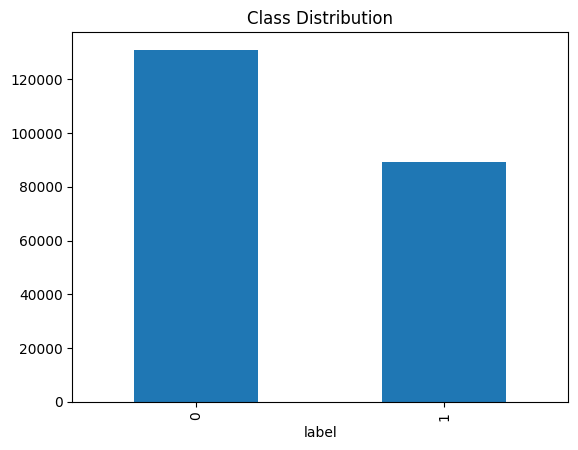

In [30]:
# Plot class distribution
train_ids['label'].value_counts().plot(kind = 'bar')
plt.title('Class Distribution')
plt.show()



In [31]:
# Add ".tif" to the id:s (unless it's already been done)
if train_ids['id'][0][-4:] != '.tif':
    train_ids['id'] = train_ids['id'] + '.tif'
    
if test_ids['id'][0][-4:] != '.tif':
    test_ids['id'] = test_ids['id'] + '.tif'
    
# Check the results
print(train_ids.head())
print(test_ids.head())

                                             id  label
0  f38a6374c348f90b587e046aac6079959adf3835.tif      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif      1
2  755db6279dae599ebb4d39a9123cce439965282d.tif      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif      0
4  068aba587a4950175d04c680d38943fd488d6a9d.tif      0
                                             id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif      0
1  95596b92e5066c5c52466c90b69ff089b39f2737.tif      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914.tif      0
3  2c35657e312966e9294eac6841726ff3a748febf.tif      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif      0


In [32]:
# Convert label column to string
train_ids['label'] = train_ids['label'].astype(str)

# Check the conversion
print(type(train_ids.iat[0, 1]))

<class 'str'>


In [33]:
train_ids.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [38]:
# Check that all IDs in train_ids correspond to files in the training set

# Create a set of all the file names in the training data directory
train_directory_file_set = set(os.listdir(train_dir))

# Check if there are any IDs in train_ids that don't occur in our set of file names.
# We hope this will generate an empty output.
train_ids[~train_ids['id'].isin(train_directory_file_set)]

,id,label


# **EDA**

## **Display some sample images**

In [ ]:
# Set up a grid of 2 rows and 8 columns
fig, axes = plt.subplots(2, 8, figsize = (15, 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Display 5 images of each class
i = 0 # Indes for the axes array
for label in ["0", "1"]:
    sample_ids = train_ids[train_ids['label'] == label]['id'].head(8)
    for img_id in sample_ids:
        img_path = train_dir + img_id
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off') # Hide the axes ticks
        i += 1 # Move to the next subplot
        
plt.tight_layout()
plt.show()

## **Check image sizes** 

It's likely that the images are all the same size, but let's check 1,000 randomly chosen.

In [ ]:
%%time
# Array to hold the image sizes we find
image_sizes = []

# Get a list of all image files in the directory
image_files = os.listdir(test_dir)

# Randomly select 10,000 image files
sample_ids = random.sample(image_files, 10000)

# Check the sizes of the randomly selected images
for image_id in sample_ids:
    image_path = os.path.join(test_dir, image_id)
    with Image.open(image_path) as img:
        image_sizes.append(img.size)

# Count the occurrences of each size
size_counts = Counter(image_sizes)

# Print the 5 most common sizes. (It's likely that there is just 1 size.)
for size, count in size_counts.most_common(5):
    print("Size:", size, "Count:", count)

# **Split the training data into training and validation sets**

In [ ]:
# Split training data into training and temp (validation/testing) sets.
train_df, val_df = train_test_split(train_ids, test_size = 0.2, random_state = 42)

# Check the sizes of the splits
print(f'Training set size: {len(train_df)}')
print(f'Validation set size: {len(val_df)}')

# **Take a sample of the data**

To speed up early hyper-parameter tuning, we'll start by training the model on just a portion of the training set, perhaps 10%. As we continue fine-tuning the hyper-parameters, we'll increase this portion to 25%, 50%, and finally to 100%.

In [ ]:
# Take just a portion of the data, for early testing
sample_fraction = 0.01 # Start with 0.1 and increase to 0.25, 0.5, and finally 1
train_df_to_use = train_df.sample(frac = sample_fraction, random_state = 42)

# Verify the sample
print(f'Full training set: {len(train_df)}')
print(f'Sampled training set: {len(train_df_to_use)}')

# **Create data generators**

In [ ]:
# Training data generator
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    zoom_range = 0.2,
    horizontal_flip = True,
    # Resize the images, for the odd chance that they are not already all 96 x 96
    preprocessing_function = lambda img : tf.image.resize(img, (96, 96))
)

# Validation data generator (no augmentation, just rescaling)
val_datagen = ImageDataGenerator(
    rescale = 1./255,
    preprocessing_function = lambda img : tf.image.resize(img, (96, 96))
)

# Test data generator (no augmentation, just rescaling)
test_datagen = ImageDataGenerator(
    rescale = 1./255,
    preprocessing_function = lambda img : tf.image.resize(img, (96, 96))
)


In [ ]:
%%time
# Training generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df_to_use,
    directory = train_dir,
    x_col = 'id',
    y_col = 'label',
    target_size = (96, 96),
    class_mode = 'binary',
    batch_size = 32
)

In [ ]:
%%time
# Validation generator
val_generator = val_datagen.flow_from_dataframe(
    dataframe = val_df,
    directory = train_dir,
    x_col = 'id',
    y_col = 'label',
    target_size = (96, 96),
    class_mode = 'binary',
    batch_size = 32
)

In [ ]:
%%time
# Test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_ids,
    directory = test_dir,
    x_col = 'id',
    y_col = None,  # No labels for test data
    target_size = (96, 96),  # Same as training
    batch_size = 32,
    class_mode = None,  # No labels
    shuffle = False  # Important to keep the order for submission
)

# **Model**
We will try two different model architectures, one simpler and one deeper.

In [ ]:
# A simple sequential model
def simple_model():
    model = Sequential([
        Input(shape=(96, 96, 3)),  # Use an Input layer here
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    return model
    
# Deeper sequential model, with dropout layer and batch normalization.
def deeper_model():
    model = Sequential([
        Input(shape=(96, 96, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),  # Add batch normalization after convolutional layers
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    return model

## **Reload saved model**
If the training of the model was interrupted, reload the model that was saved after the last completed epoch. Adjust the remaining number of epochs accordingly.

In [ ]:
# Load the model from the saved checkpoint
try:
    model = load_model('kaggle/working/model_checkpoint.keras')
except (FileNotFoundError, ValueError):
    # Chose model to use: comment out one of the two lines
    model = simple_model()
#     model = deeper_model()

    model.compile(optimizer='adam', 
                  learning_rate = 0.001,
                  loss='binary_crossentropy', 
                  metrics=['AUC'])

    # Compile the model with a different optimizer
    # model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
# Display the model summary
model.summary()

# **Custom logger**
This custom logger will be used to display the progress during the training.

In [ ]:
class ProgressLogger(Callback):
    def __init__(self, **kwargs):
        super().__init__(**kwargs) 
        self.epoch_start_time = None

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()
        print(f"\nEpoch {epoch+1} starting...")

    def on_epoch_end(self, epoch, logs=None):
        elapsed_time = time.time() - self.epoch_start_time
        print(f"Epoch {epoch+1} ended. Elapsed time: {elapsed_time:.2f} seconds")
        print(f"Logs: {logs}")
        
        # Save th current epoch number to a file
        with open('epoch_log.json', 'w') as f:
            json.dump({'last_epoch': epoch + 1}, f)

    def on_batch_end(self, batch, logs=None):
        if batch % 100 == 0:  # Print progress every 100 batches
            print(f"\nProcessing batch {batch}")

# **Train the model**

In [ ]:
%%time

# Calculate the weight of each class
class_0_count, class_1_count = train_ids['label'].value_counts()
total_count = class_0_count + class_1_count

# Set the class weights inversely proportional to class frequencies
class_weights = {
    0: total_count / (2 * class_0_count),
    1: total_count / (2 * class_1_count)
}

# Define checkpoint callback
checkpoint = ModelCheckpoint(
    filepath = 'model_checkpoint.keras',  # Where to save the model file
    monitor = 'val_loss',              # You can change this to 'val_accuracy' or another metric
    save_best_only = False,            # Save the model after every epoch
    save_weights_only = False,         # Save the entire model (including architecture)
    mode = 'auto',                     # Mode for monitoring the metric
    verbose = 1                        # Print a message each time the model is saved
)

# Load the last epoch if available
try:
    with open('epoch_log.json', 'r') as f:
        epoch_data = json.load(f)
        initial_epoch = epoch_data['last_epoch']
except FileNotFoundError:
    initial_epoch = 0

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience = 2, restore_best_weights = True)
    
# Train the model with the custom callback
history = model.fit(
    train_generator,
    epochs = 20,
    validation_data = val_generator,
    class_weight=class_weights,
    callbacks = [ProgressLogger(), TqdmCallback(verbose = 1), checkpoint, early_stopping],
    initial_epoch = initial_epoch
)

# Extract final validation accuracy
final_val_accuracy = history.history['val_accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Validation Accuracy: {final_val_accuracy}")
print(f"Final Validation Loss: {final_val_loss}")

# **Make predictions, and generate submission file**

In [ ]:
%%time

# Make predictions on the test data
predictions = model.predict(test_generator, verbose = 1)

In [ ]:
# The sample_submission file contains the test id:s
submission = pd.read_csv(main_dir + 'sample_submission.csv')

# Enter the predictions into the "label" column.
# (The instructions says that this column should contain probabilities,
# but be named "labels". Not an ideal arrangement, in my mind.)
submission['label'] = predictions

# Take a look
submission[:5]

In [ ]:
# Generate a unique filename with a timestamp
timestamp = datetime.now().strftime('%Y-%m-%d_%H%M')
filename = f'submission_{timestamp}.csv'

# Gnerate the submission file
submission.to_csv(filename, index = False)

# Generate a download link.
FileLink(rf'{filename}')